In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm.autonotebook import tqdm
from joblib import Parallel, delayed
import umap
import pandas as pd
from datetime import datetime


/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [3]:
from avgn.utils.paths import DATA_DIR, most_recent_subdirectory, ensure_dir

In [4]:
DATASET_ID = 'BIRD_DB_Toxostoma_redivivum_segmented'

In [5]:
# create a unique datetime identifier for the files output by this notebook
DT_ID = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
DT_ID

'2019-11-14_10-41-30'

In [6]:
from avgn.utils.hparams import HParams
from avgn.dataset import DataSet

In [7]:
from avgn.signalprocessing.create_spectrogram_dataset import prepare_wav, create_label_df, get_row_audio

### create dataset

In [8]:
hparams = HParams(
    num_mel_bins = 32,
    mel_lower_edge_hertz=500,
    mel_upper_edge_hertz=10000,
    butter_lowcut = 500,
    butter_highcut = 10000,
    ref_level_db = 20,
    min_level_db = -25,
    mask_spec = True,
    win_length_ms = 10,
    hop_length_ms = 2,
    mask_spec_kwargs = {"spec_thresh": 0.9, "offset": 1e-10}
)

In [9]:
# create a dataset object
dataset = DataSet(DATASET_ID, hparams = hparams)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done 832 tasks      | elapsed:    5.6s


[Parallel(n_jobs=-1)]: Done 15248 out of 15248 | elapsed:    7.8s finished


In [10]:
dataset.sample_json

OrderedDict([('TrackName', 'tCOMM09-7'),
             ('type_of_device', 'single microphone'),
             ('configuration', 'MOC2012'),
             ('microphone',
              'Sennheiser omnidirectional with Telinga parabolic reflector'),
             ('recorder', 'Marantz PMD650'),
             ('sample_rate', 44.0),
             ('Recordist_first_name', 'Martin'),
             ('Recordist_last_name', 'Cody'),
             ('recording_date', '2009-03-21_00-00-00'),
             ('recording_time', '08:44:00'),
             ('recording_length', '00:01:30'),
             ('Audio_file',
              'http://taylor0.biology.ucla.edu/birdDBQuery/Files/Tracks/2009/March/CATH7.WAV'),
             ('SubjectName', 'CATH-CP1'),
             ('subject_importance', 'Primary subject'),
             ('quality_rating', 4.0),
             ('Species_short_name', 'CATH'),
             ('Subject_species', 'California Thrasher'),
             ('sex', 'Male(s)'),
             ('age_class', 'Reproduct

#### Create dataset based upon JSON

In [11]:
from joblib import Parallel, delayed
n_jobs = -1; verbosity = 1

In [12]:
with Parallel(n_jobs=n_jobs, verbose=verbosity) as parallel:
    syllable_dfs = parallel(
        delayed(create_label_df)(
            dataset.data_files[key].data,
            hparams=dataset.hparams,
            labels_to_retain=[],
            unit="syllables",
            dict_features_to_retain = ['label'],
            key = key,
        )
        for key in tqdm(dataset.data_files.keys())
    )
syllable_df = pd.concat(syllable_dfs)
len(syllable_df)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 200 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 1700 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done 3800 tasks      | elapsed:    8.6s
[Parallel(n_jobs=-1)]: Done 6500 tasks      | elapsed:   13.8s
[Parallel(n_jobs=-1)]: Done 9800 tasks      | elapsed:   20.0s
[Parallel(n_jobs=-1)]: Done 13700 tasks      | elapsed:   27.4s


[Parallel(n_jobs=-1)]: Done 15248 out of 15248 | elapsed:   30.0s finished


20590

In [13]:
syllable_df[:3]

,start_time,end_time,indv,indvi,label,key
0,24.452796,24.545296,CATH-CP1,0,nhv,2009-03-21_08-44-00-000000_1669
0,388.917194,389.066694,CATH-TLR8,0,avb,2012-03-29_07-55-00-000000_13484
0,50.144617,50.266617,CATH-TLR12,0,anj,2012-03-27_08-12-00-000000_11234


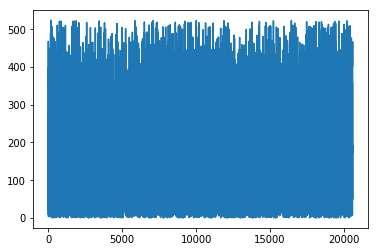

In [14]:
plt.plot(syllable_df.start_time.values)

### get audio for dataset

In [15]:
with Parallel(n_jobs=n_jobs, verbose=verbosity) as parallel:
    syllable_df = pd.concat( parallel(
        delayed(get_row_audio)(
            syllable_df[syllable_df.key == key], 
            dataset.data_files[key].data['wav_loc'], 
            dataset.hparams
        )
        for key in tqdm(syllable_df.key.unique())
    ))
len(syllable_df)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done  19 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 229 tasks      | elapsed:    7.9s
/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done 479 tasks      | elapsed:   16.6s
[Parallel(n_jobs=-1)]: Done 829 tasks      | elapsed:   28.2s
[Parallel(n_jobs=-1)]: Done 1279 tasks      | elapsed:   43.4s
[Parallel(n_jobs=-1)]: Done 1829 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 2479 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 3229 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 4079 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 5029 tasks      | elapsed:  2.7m

[Parallel(n_jobs=-1)]: Done 14757 out of 14757 | elapsed:  7.8min finished


20590

In [16]:
syllable_df[:3]

,start_time,end_time,indv,indvi,label,key,audio,rate
0,24.452796,24.545296,CATH-CP1,0,nhv,2009-03-21_08-44-00-000000_1669,"[0.0021329888, 0.0022021271, 0.00030969633, -0...",44100
0,388.917194,389.066694,CATH-TLR8,0,avb,2012-03-29_07-55-00-000000_13484,"[0.0028634989, 0.0019004839, 0.0006606924, -0....",44100
0,50.144617,50.266617,CATH-TLR12,0,anj,2012-03-27_08-12-00-000000_11234,"[0.0066728853, 0.0032954316, -0.0021555573, -0...",44100


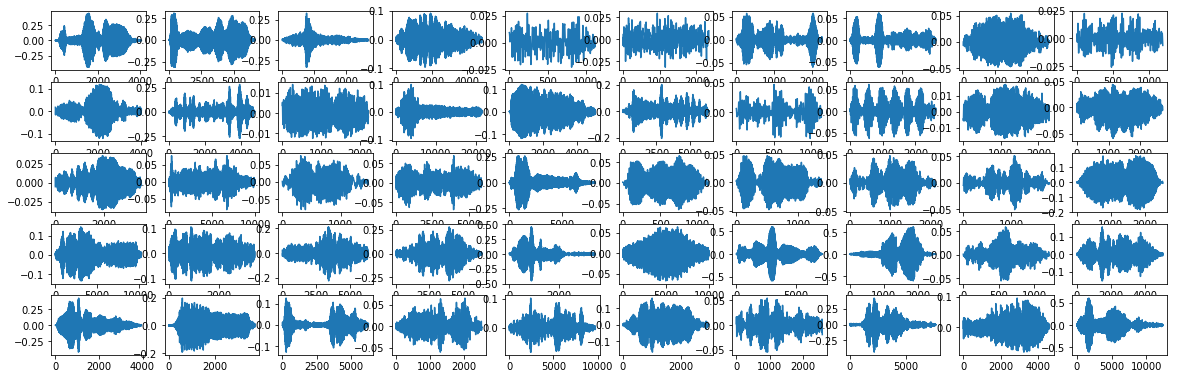

In [17]:
nrows = 5
ncols = 10
sylls = syllable_df.audio.values[:nrows*ncols]
zoom = 2
fig, axs = plt.subplots(ncols=ncols, nrows = nrows,figsize = (ncols*zoom, nrows+zoom/1.5))
for i, syll in tqdm(enumerate(sylls), total = nrows*ncols):
    ax = axs.flatten()[i]
    ax.plot(syll)

In [25]:
audio_lens = np.array([len(i) for i in syllable_df['audio']])

(array([3.000e+00, 0.000e+00, 2.278e+03, 2.069e+03, 1.914e+03, 2.020e+03,
        1.994e+03, 1.658e+03, 1.382e+03, 1.188e+03, 1.019e+03, 9.410e+02,
        6.410e+02, 5.720e+02, 5.580e+02, 5.220e+02, 3.840e+02, 2.710e+02,
        2.460e+02, 1.830e+02, 1.210e+02, 1.150e+02, 8.200e+01, 8.700e+01,
        6.600e+01, 6.400e+01, 5.100e+01, 4.400e+01, 2.400e+01, 2.000e+01,
        1.000e+01, 1.200e+01, 1.300e+01, 6.000e+00, 6.000e+00, 4.000e+00,
        5.000e+00, 7.000e+00, 4.000e+00, 3.000e+00, 0.000e+00, 1.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00]),
 array([    0.  ,   547.72,  1095.44,  1643.16,  2190.88,  2738.6 ,
         3286.32,  3834.04,  4381.76,  4929.48,  5477.2 ,  6024.92,
         6572.64,  7120.36,  7668.08,  8215.8 ,  8763.52,  9311.24,
         9858.96, 10406.68, 10954.4 , 11502.12, 12049.84, 12597.56,
        13145.28, 13693.  , 14240.72, 14788.44, 15336.16, 15883.88,
        16431.6 , 16979.32, 17527.04

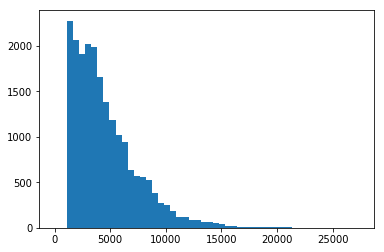

In [26]:
plt.hist(audio_lens, bins=50)

In [28]:
mask = (audio_lens > 100)
syllable_df = syllable_df[mask]

In [29]:
syllable_df['audio'] = [i/np.max(np.abs(i)) for i in tqdm(syllable_df.audio.values)]

### Create spectrograms

In [30]:
from avgn.visualization.spectrogram import draw_spec_set
from avgn.signalprocessing.create_spectrogram_dataset import make_spec, mask_spec, log_resize_spec, pad_spectrogram

In [31]:
with Parallel(n_jobs=n_jobs, verbose=verbosity) as parallel:
    # create spectrograms
    syllables_spec = parallel(
        delayed(make_spec)(
            syllable,
            rate,
            hparams=hparams,
            mel_matrix=dataset.mel_matrix,
            use_mel=True,
            use_tensorflow=False,
        )
        for syllable, rate in tqdm(
            zip(syllable_df.audio.values, syllable_df.rate.values),
            total=len(syllable_df),
            desc="getting syllable spectrograms",
            leave=False,
        )
    )

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 1168 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 9168 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 20587 out of 20587 | elapsed:    6.1s finished


### Rescale spectrogram
- using log rescaling

In [32]:
log_scaling_factor = 4

In [33]:
with Parallel(n_jobs=n_jobs, verbose=verbosity) as parallel:
    syllables_spec = parallel(
        delayed(log_resize_spec)(spec, scaling_factor=log_scaling_factor)
        for spec in tqdm(syllables_spec, desc="scaling spectrograms", leave=False)
    )

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done 624 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 20587 out of 20587 | elapsed:    2.5s finished


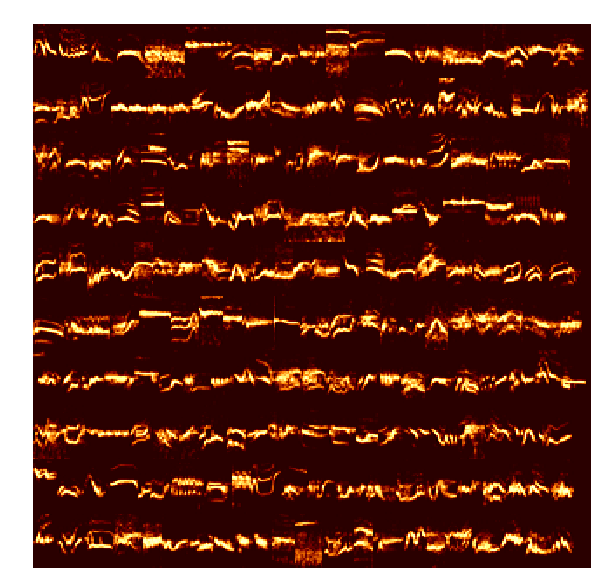

In [34]:
draw_spec_set(syllables_spec, zoom=1, maxrows=10, colsize=10)

### Pad spectrograms

In [35]:
syll_lens = [np.shape(i)[1] for i in syllables_spec]
pad_length = np.max(syll_lens)

In [36]:
syllable_df[:3]

,start_time,end_time,indv,indvi,label,key,audio,rate
0,24.452796,24.545296,CATH-CP1,0,nhv,2009-03-21_08-44-00-000000_1669,"[0.0047750124, 0.004929789, 0.0006933013, -0.0...",44100
0,388.917194,389.066694,CATH-TLR8,0,avb,2012-03-29_07-55-00-000000_13484,"[0.00909156, 0.0060340036, 0.002097687, -0.002...",44100
0,50.144617,50.266617,CATH-TLR12,0,anj,2012-03-27_08-12-00-000000_11234,"[0.019762523, 0.009759802, -0.0063839327, -0.0...",44100


In [37]:
import seaborn as sns

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


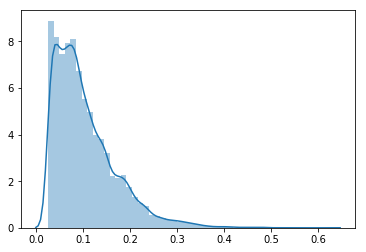

In [38]:
sns.distplot((syllable_df["end_time"] - syllable_df["start_time"]))
#plt.legend()

In [39]:
with Parallel(n_jobs=n_jobs, verbose=verbosity) as parallel:

    syllables_spec = parallel(
        delayed(pad_spectrogram)(spec, pad_length)
        for spec in tqdm(
            syllables_spec, desc="padding spectrograms", leave=False
        )
    )

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 3840 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 17340 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 20587 out of 20587 | elapsed:    2.7s finished


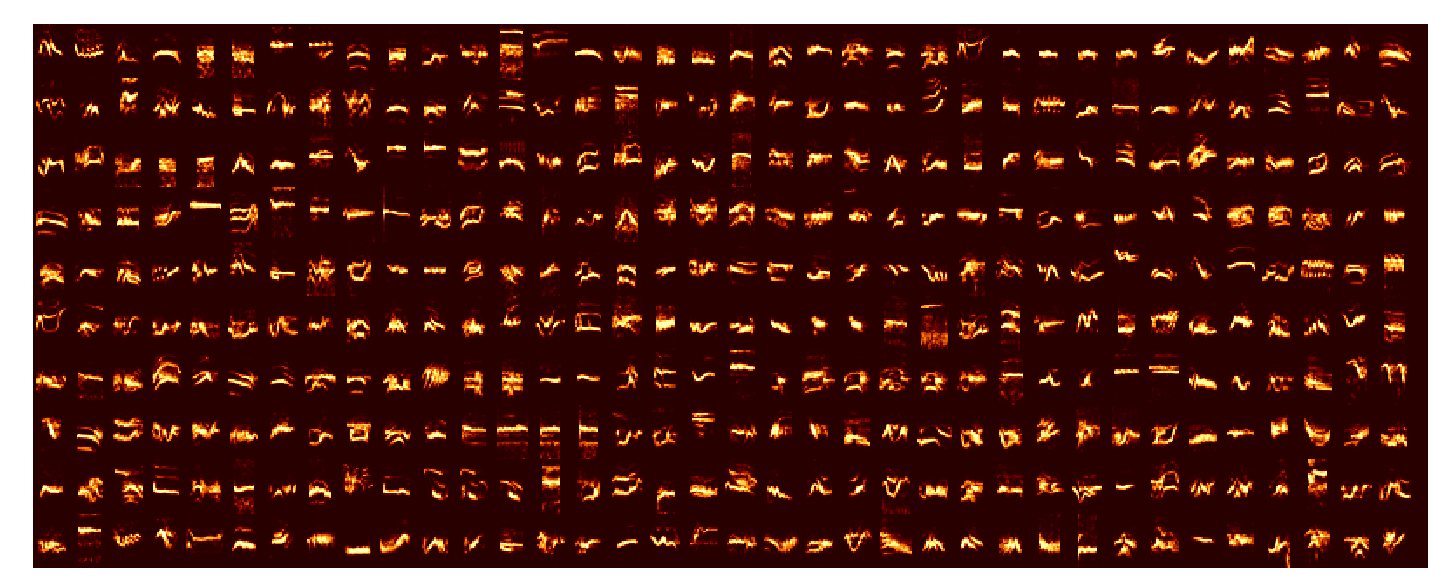

In [40]:
draw_spec_set(syllables_spec, zoom=1, maxrows=10, colsize=25)

In [41]:
syllable_df['spectrogram'] = syllables_spec

In [42]:
syllable_df[:3]

,start_time,end_time,indv,indvi,label,key,audio,rate,spectrogram
0,24.452796,24.545296,CATH-CP1,0,nhv,2009-03-21_08-44-00-000000_1669,"[0.0047750124, 0.004929789, 0.0006933013, -0.0...",44100,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
0,388.917194,389.066694,CATH-TLR8,0,avb,2012-03-29_07-55-00-000000_13484,"[0.00909156, 0.0060340036, 0.002097687, -0.002...",44100,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
0,50.144617,50.266617,CATH-TLR12,0,anj,2012-03-27_08-12-00-000000_11234,"[0.019762523, 0.009759802, -0.0063839327, -0.0...",44100,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."


In [43]:
# remove noise spectrograms
syll_shape = np.shape(syllables_spec[0])
bad_specs = np.array([np.argmax(np.sum(i, axis=1)) > ((syll_shape[0]*.9)-1) for i in syllables_spec])
print(np.sum(bad_specs))

19


In [44]:
syllable_df = syllable_df[bad_specs==False]

In [45]:
len(syllable_df)

20568

### view syllables per indv

In [46]:
syllable_df.indv.unique()

array(['CATH-CP1', 'CATH-TLR8', 'CATH-TLR12', 'CATH-TLR9', 'CATH-TLR2',
       'CATH-TLR7', 'CATH-TLR1', 'CATH-TLR5 in 2013', 'CATH-TLR3',
       'CATH-TLR11', 'CATH-TLR6', 'CATH-TLR5', 'CATH-TLR10', 'CATH-TLR4',
       'CATH-TLR14', 'CATH-CCCAJ', 'CATH-CCCAI', 'CATH-TLR13'],
      dtype=object)

In [47]:
len(syllable_df)

20568

CATH-CP1 3644


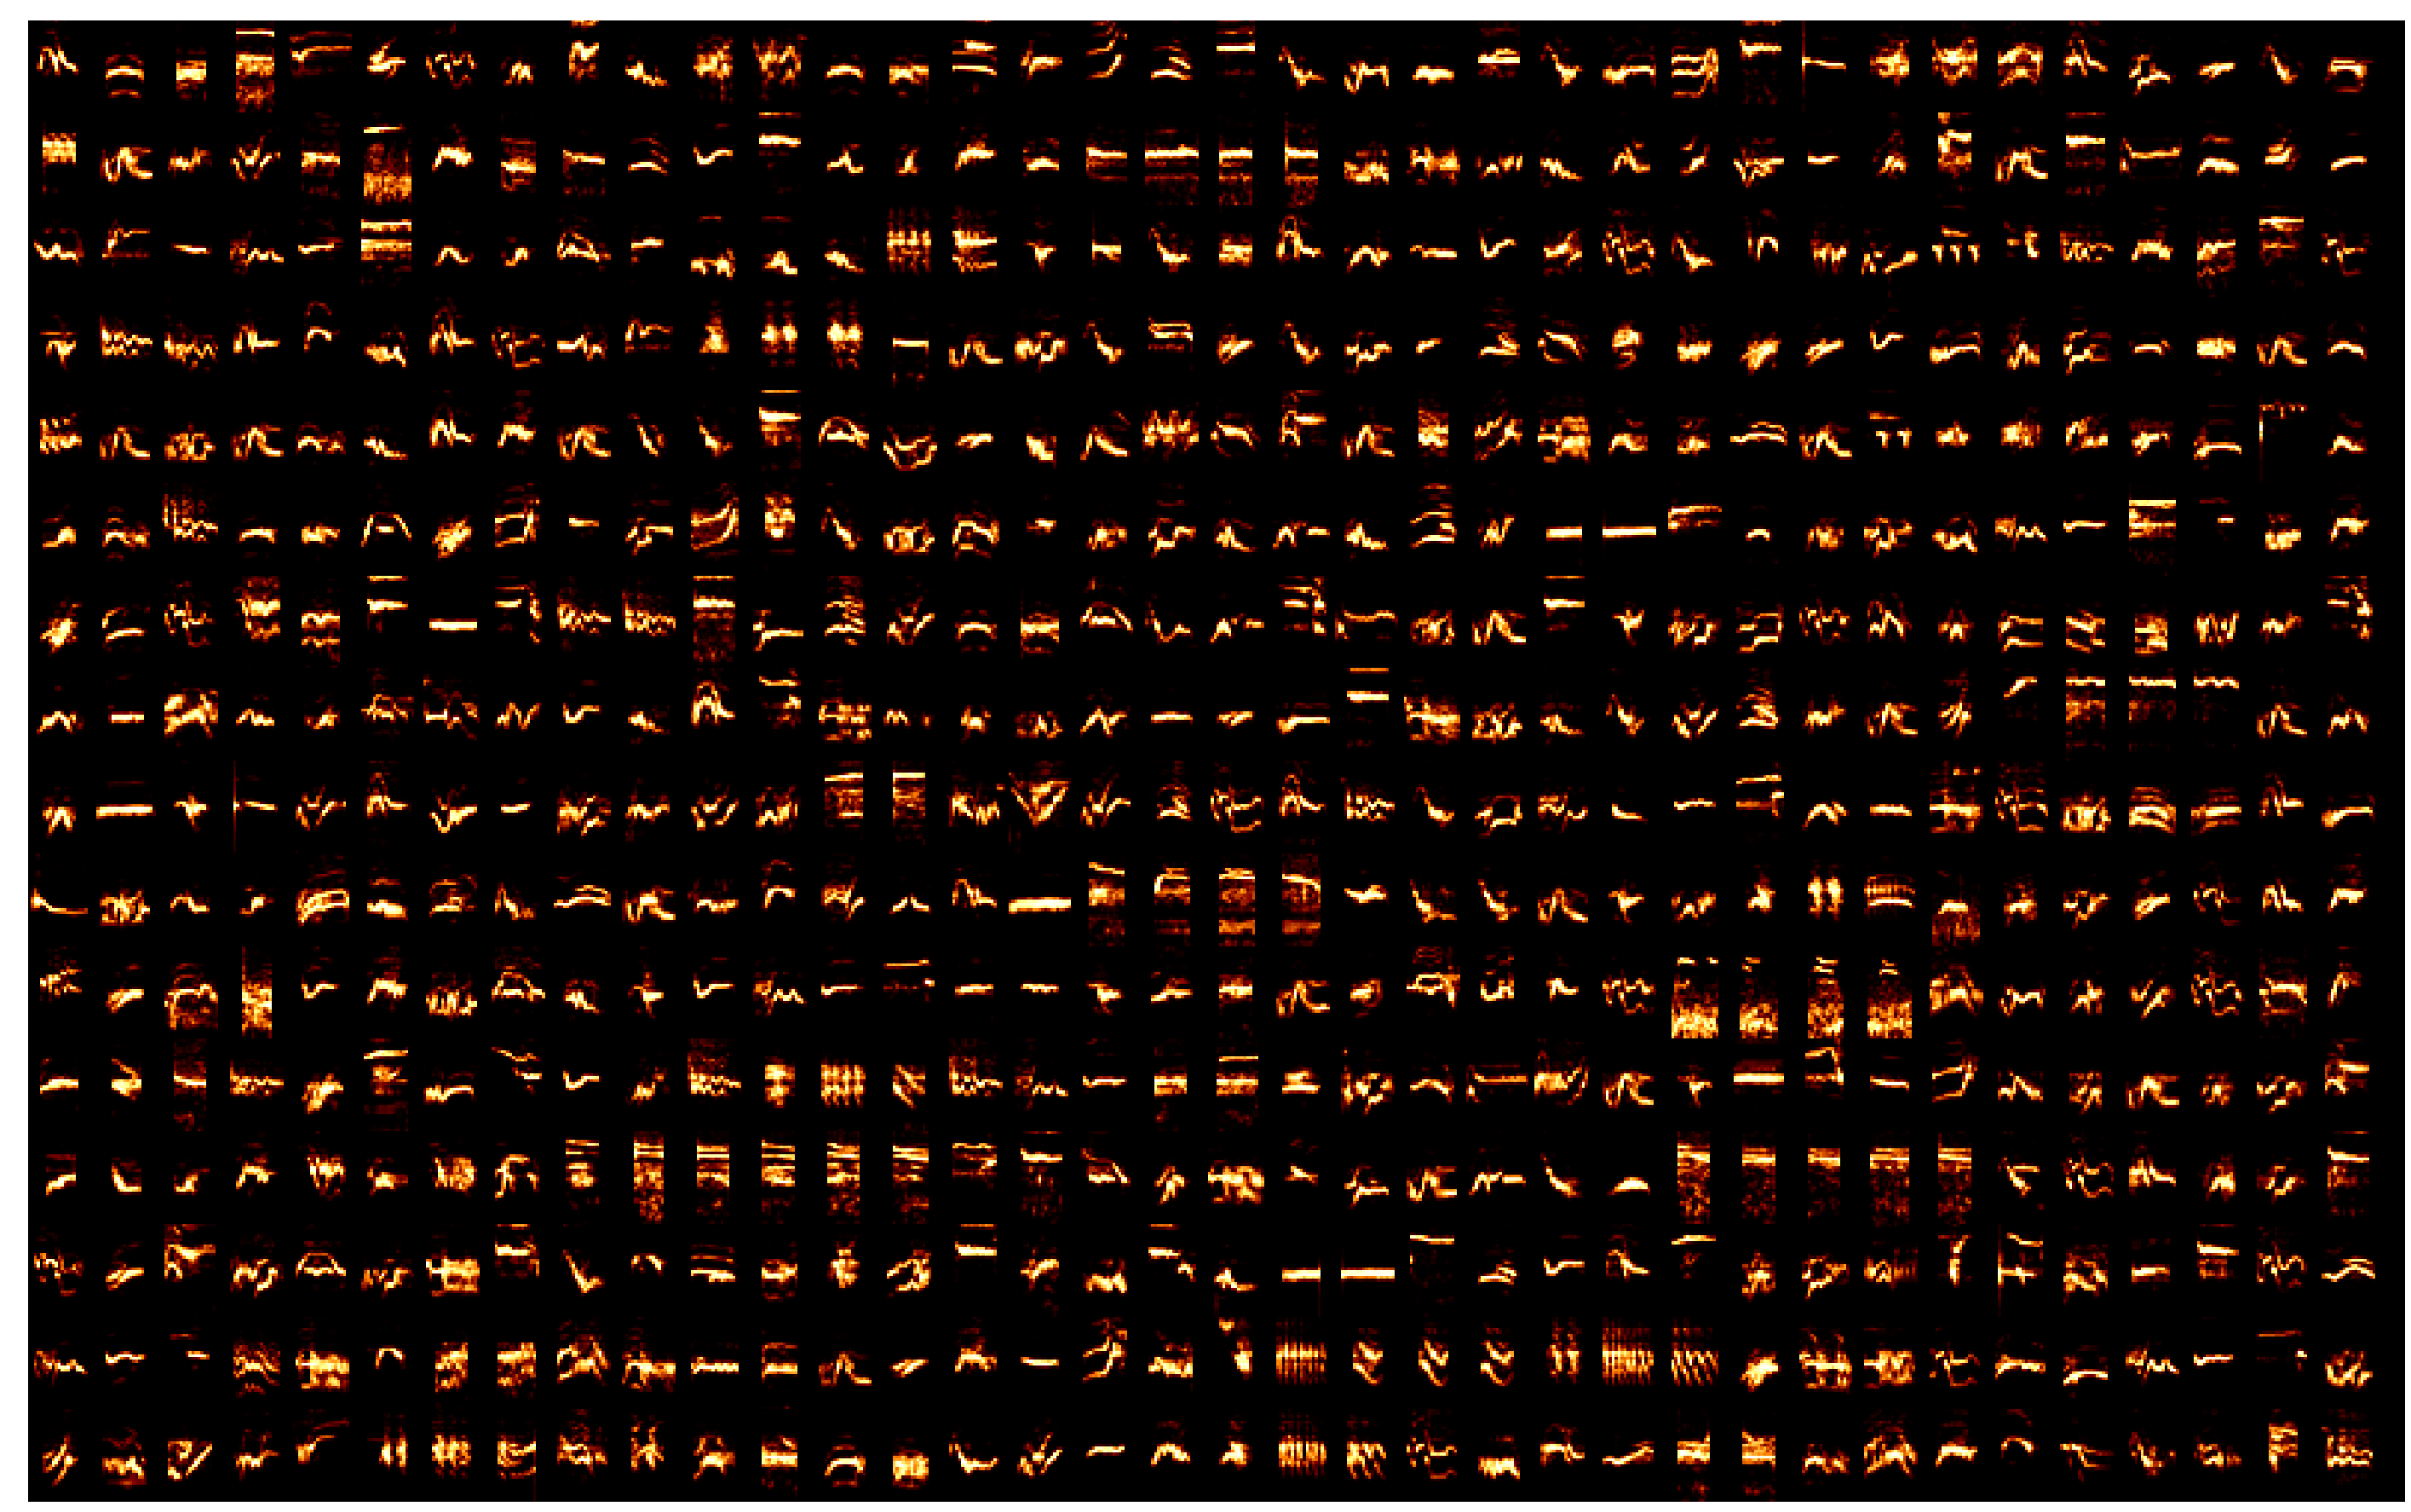

CATH-TLR12 883


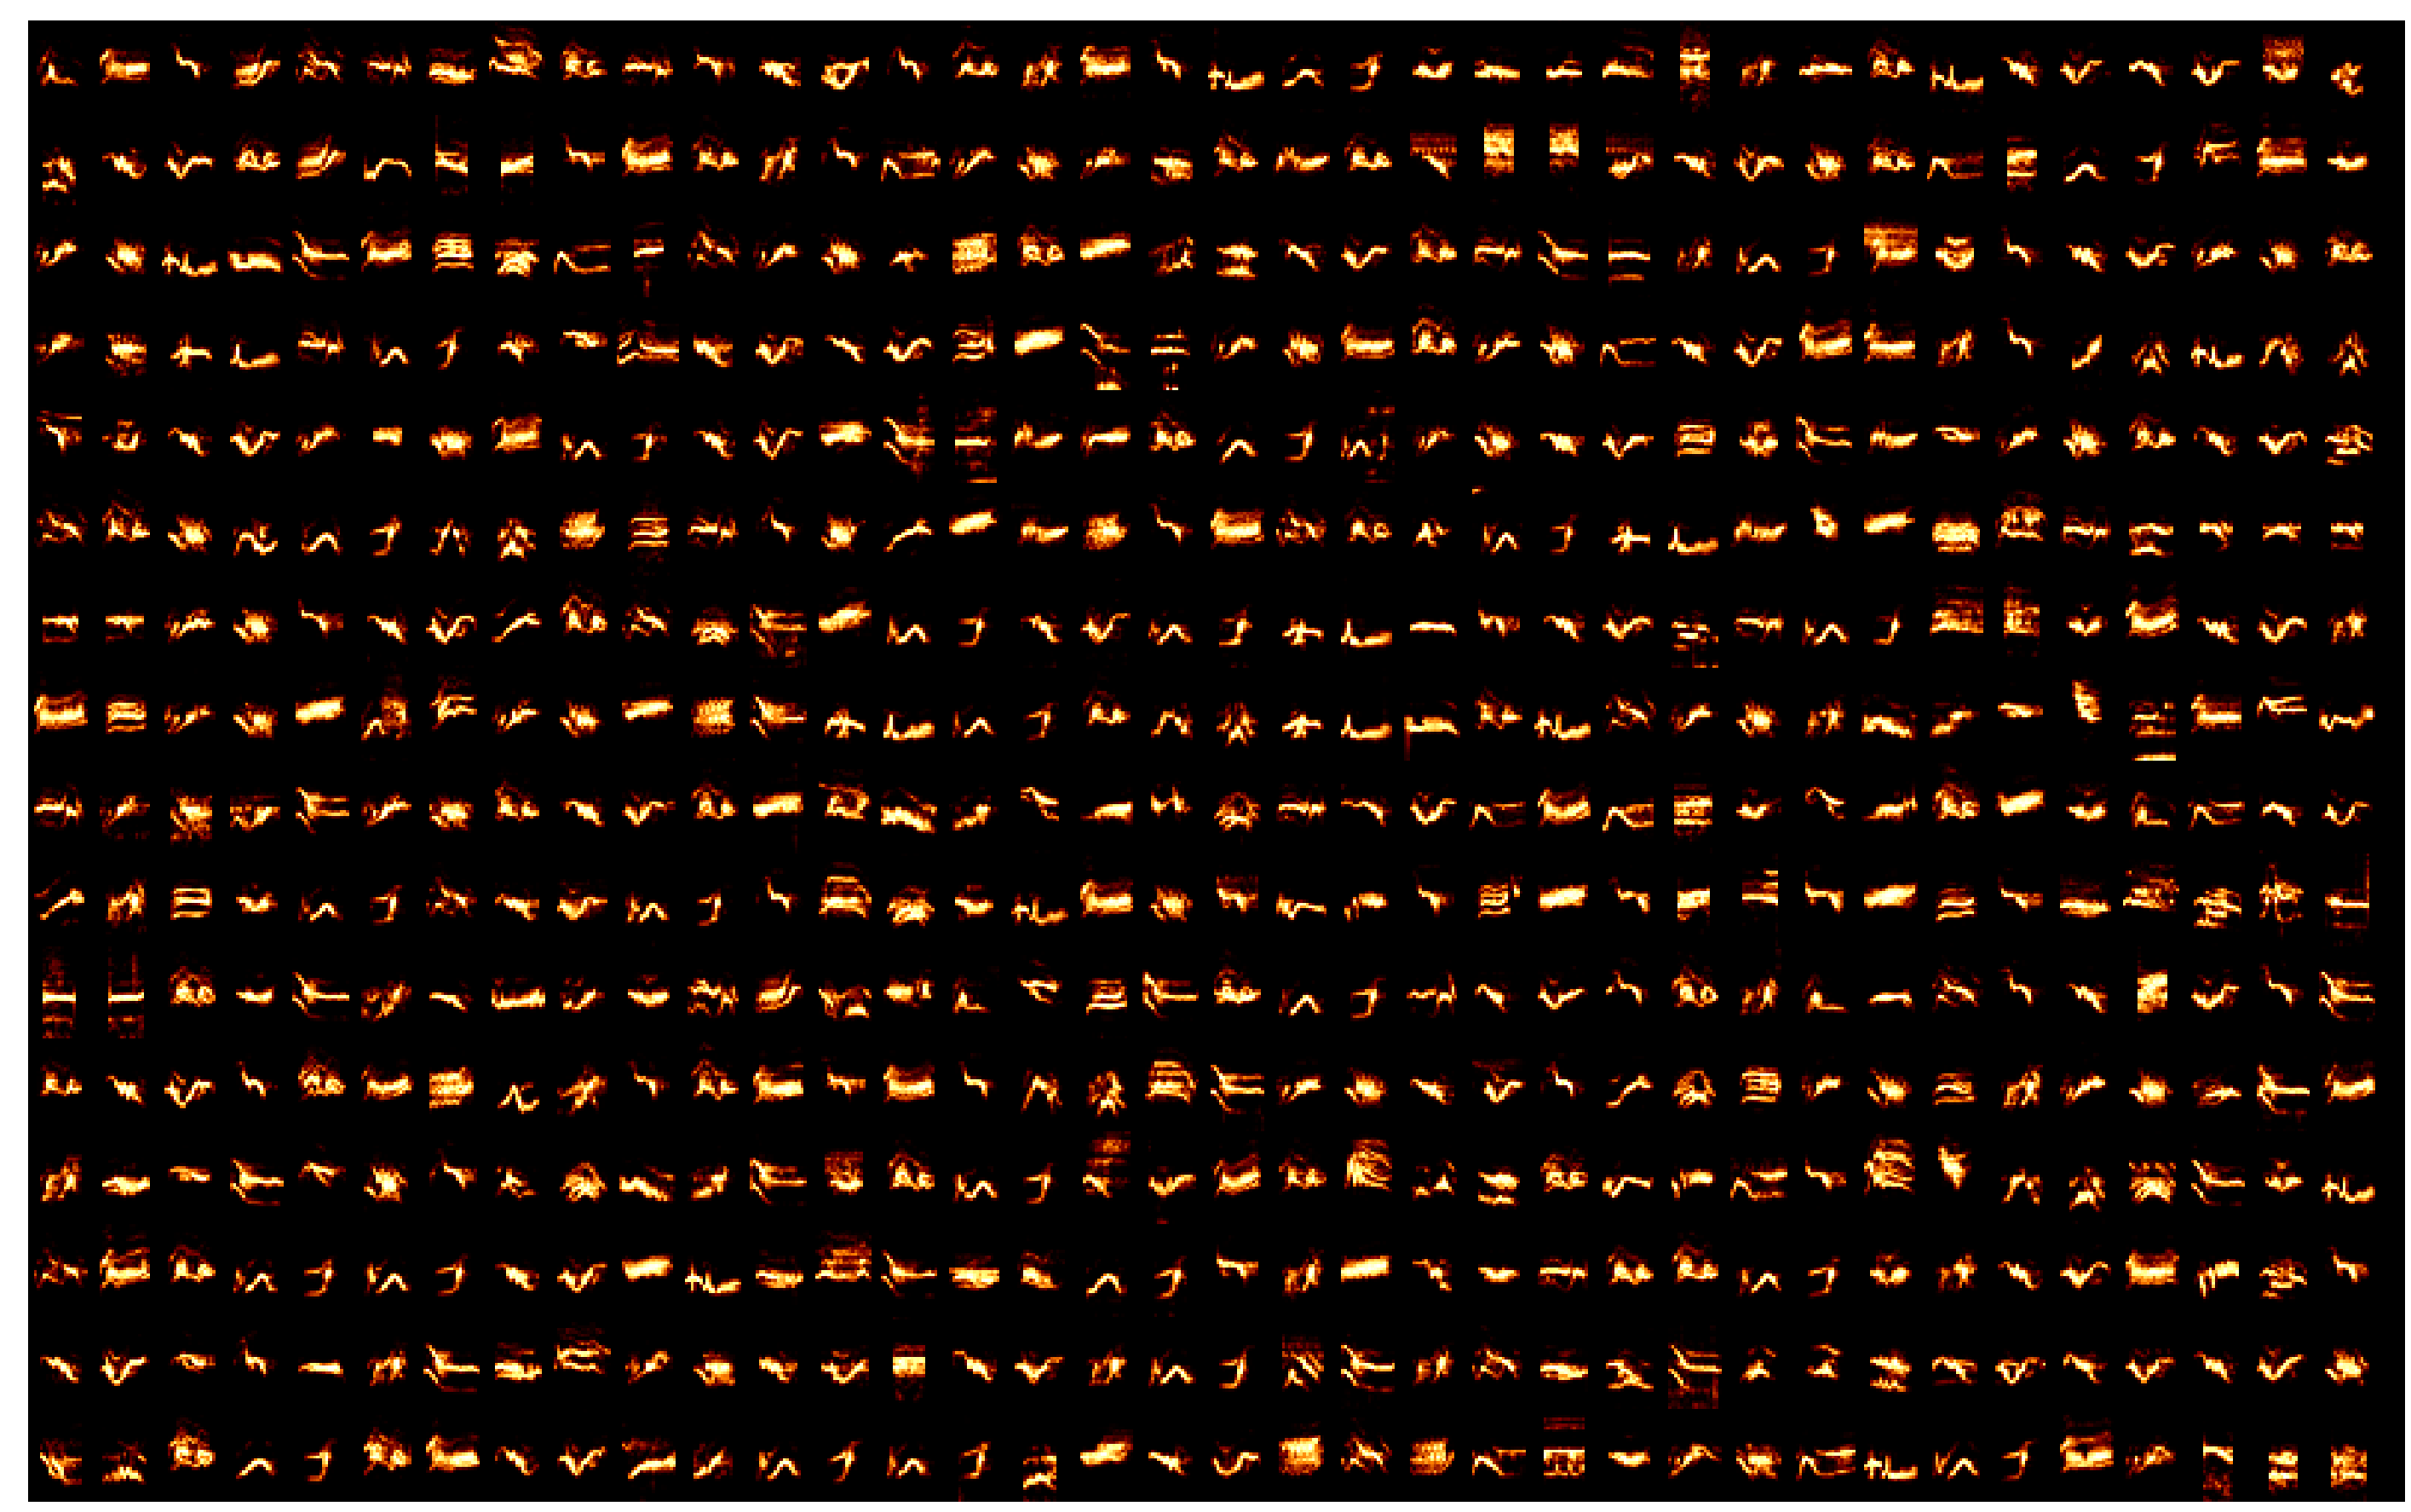

CATH-TLR2 1541


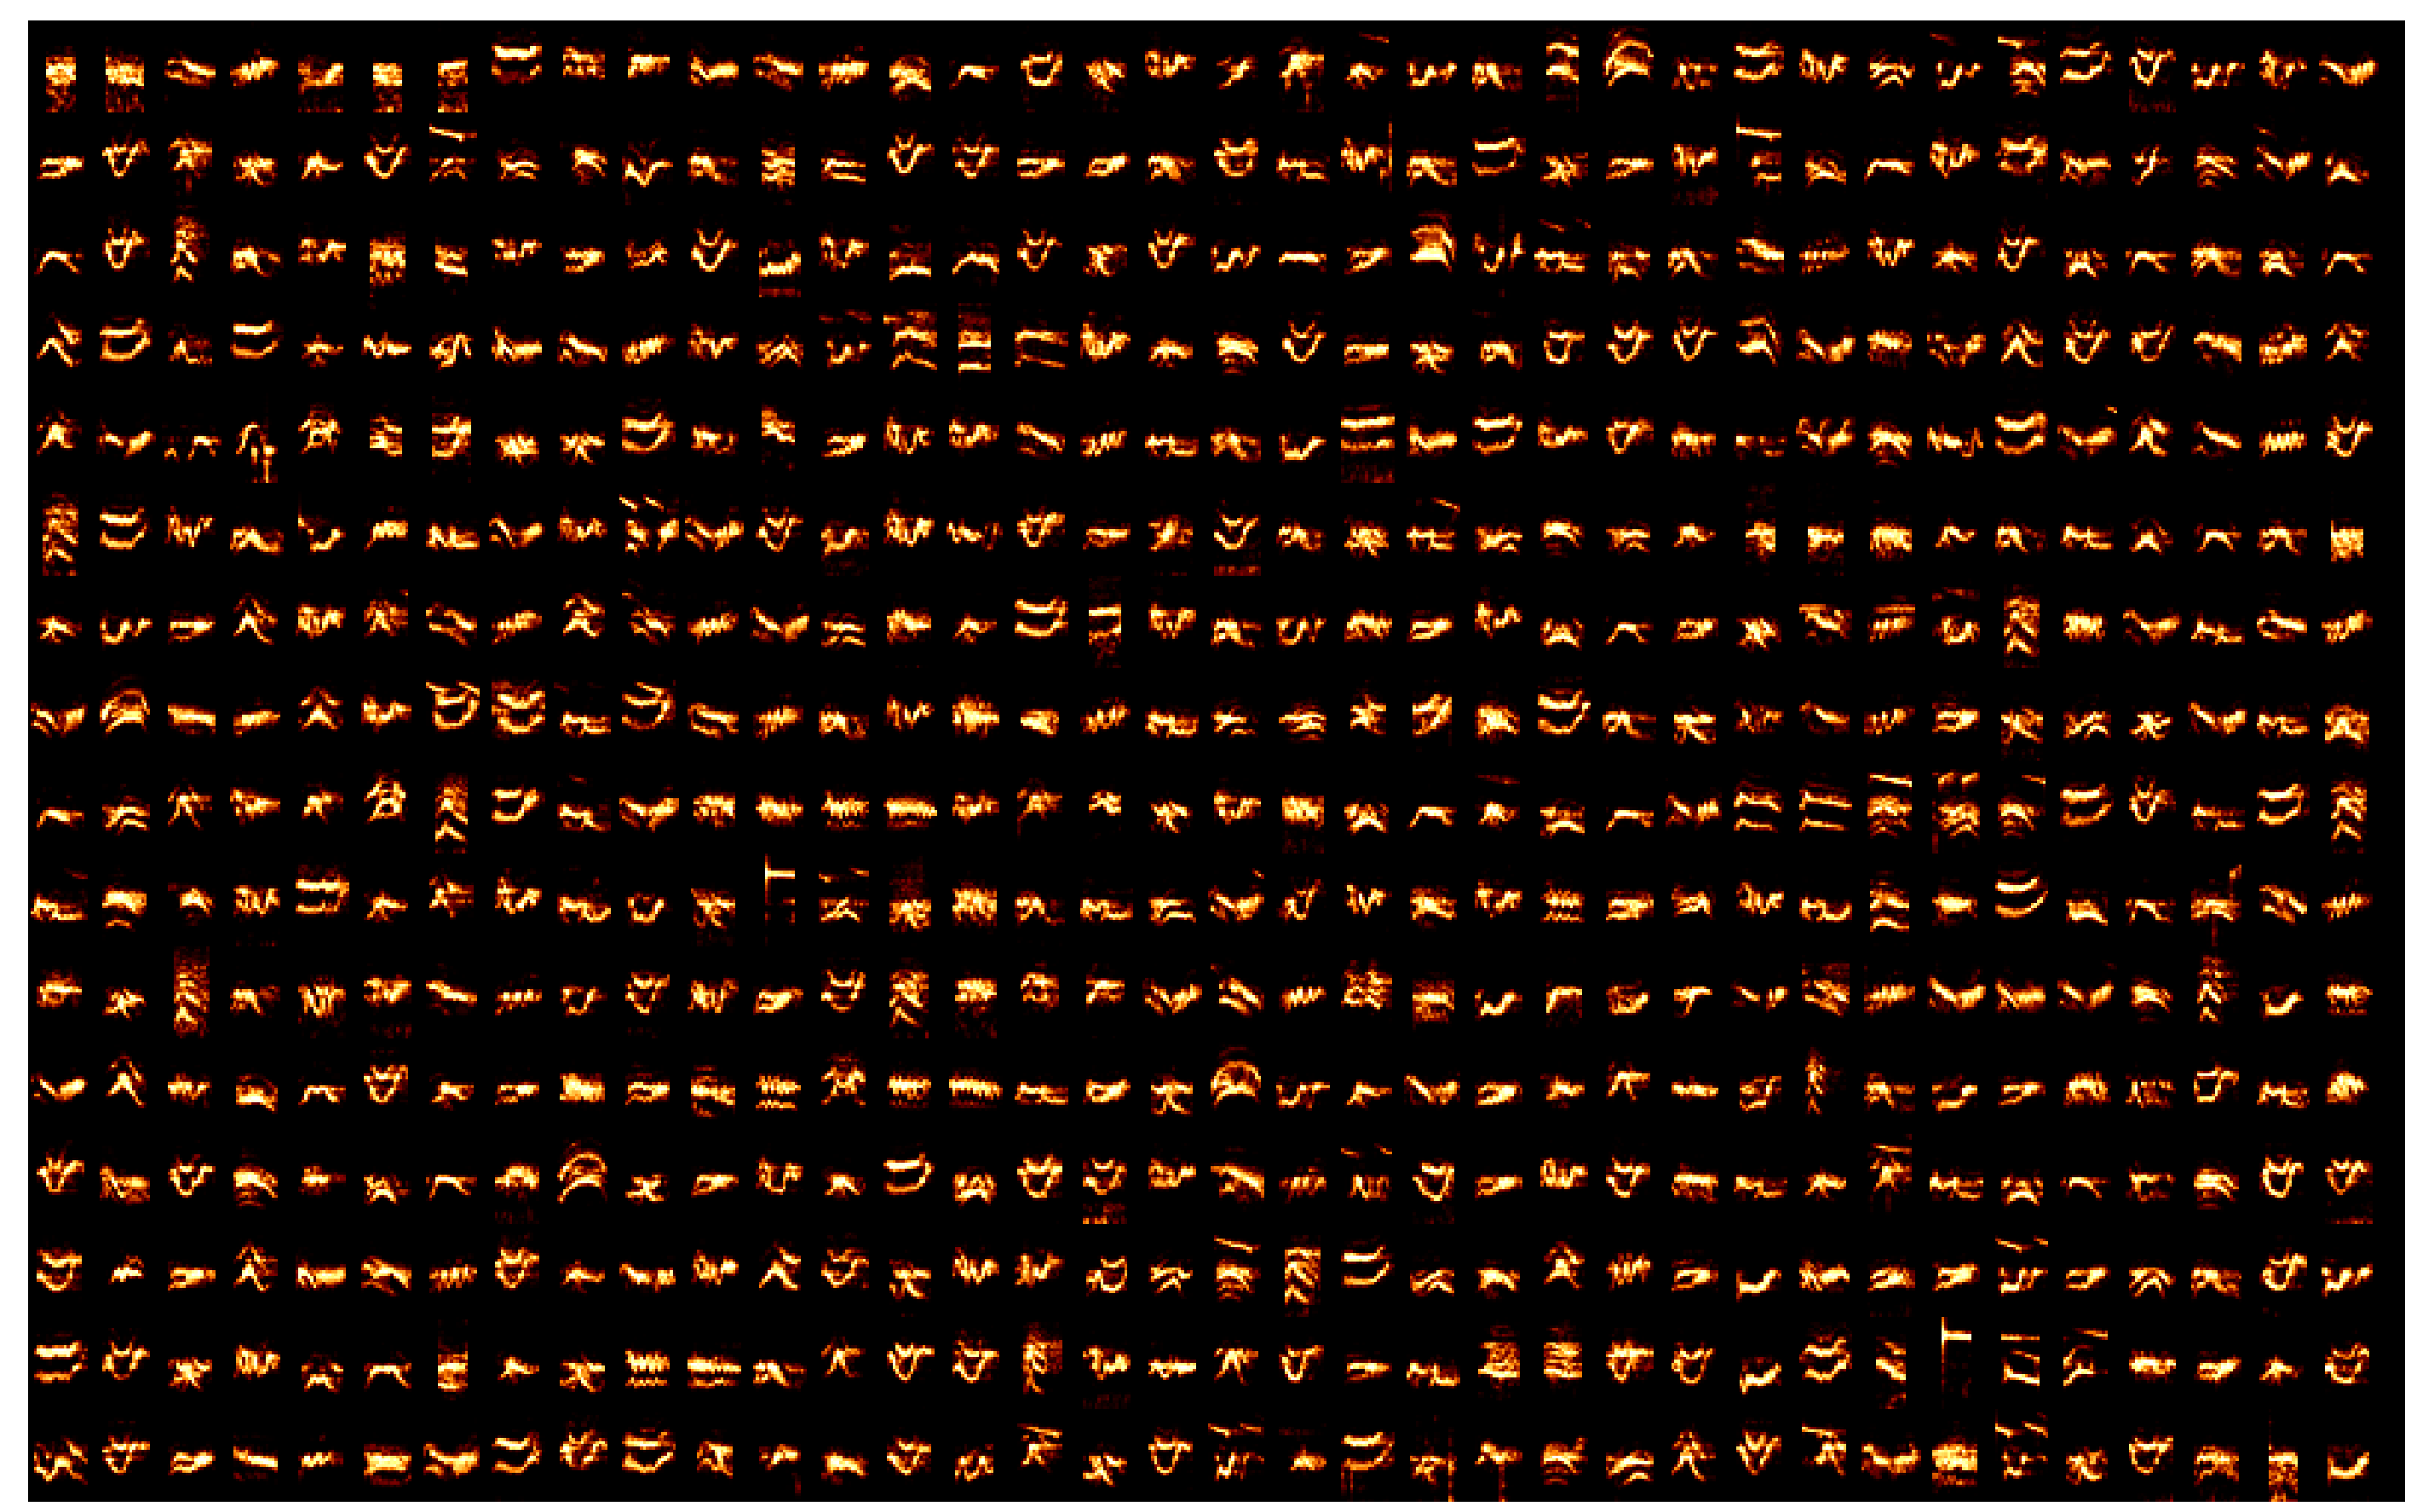

CATH-TLR8 2748


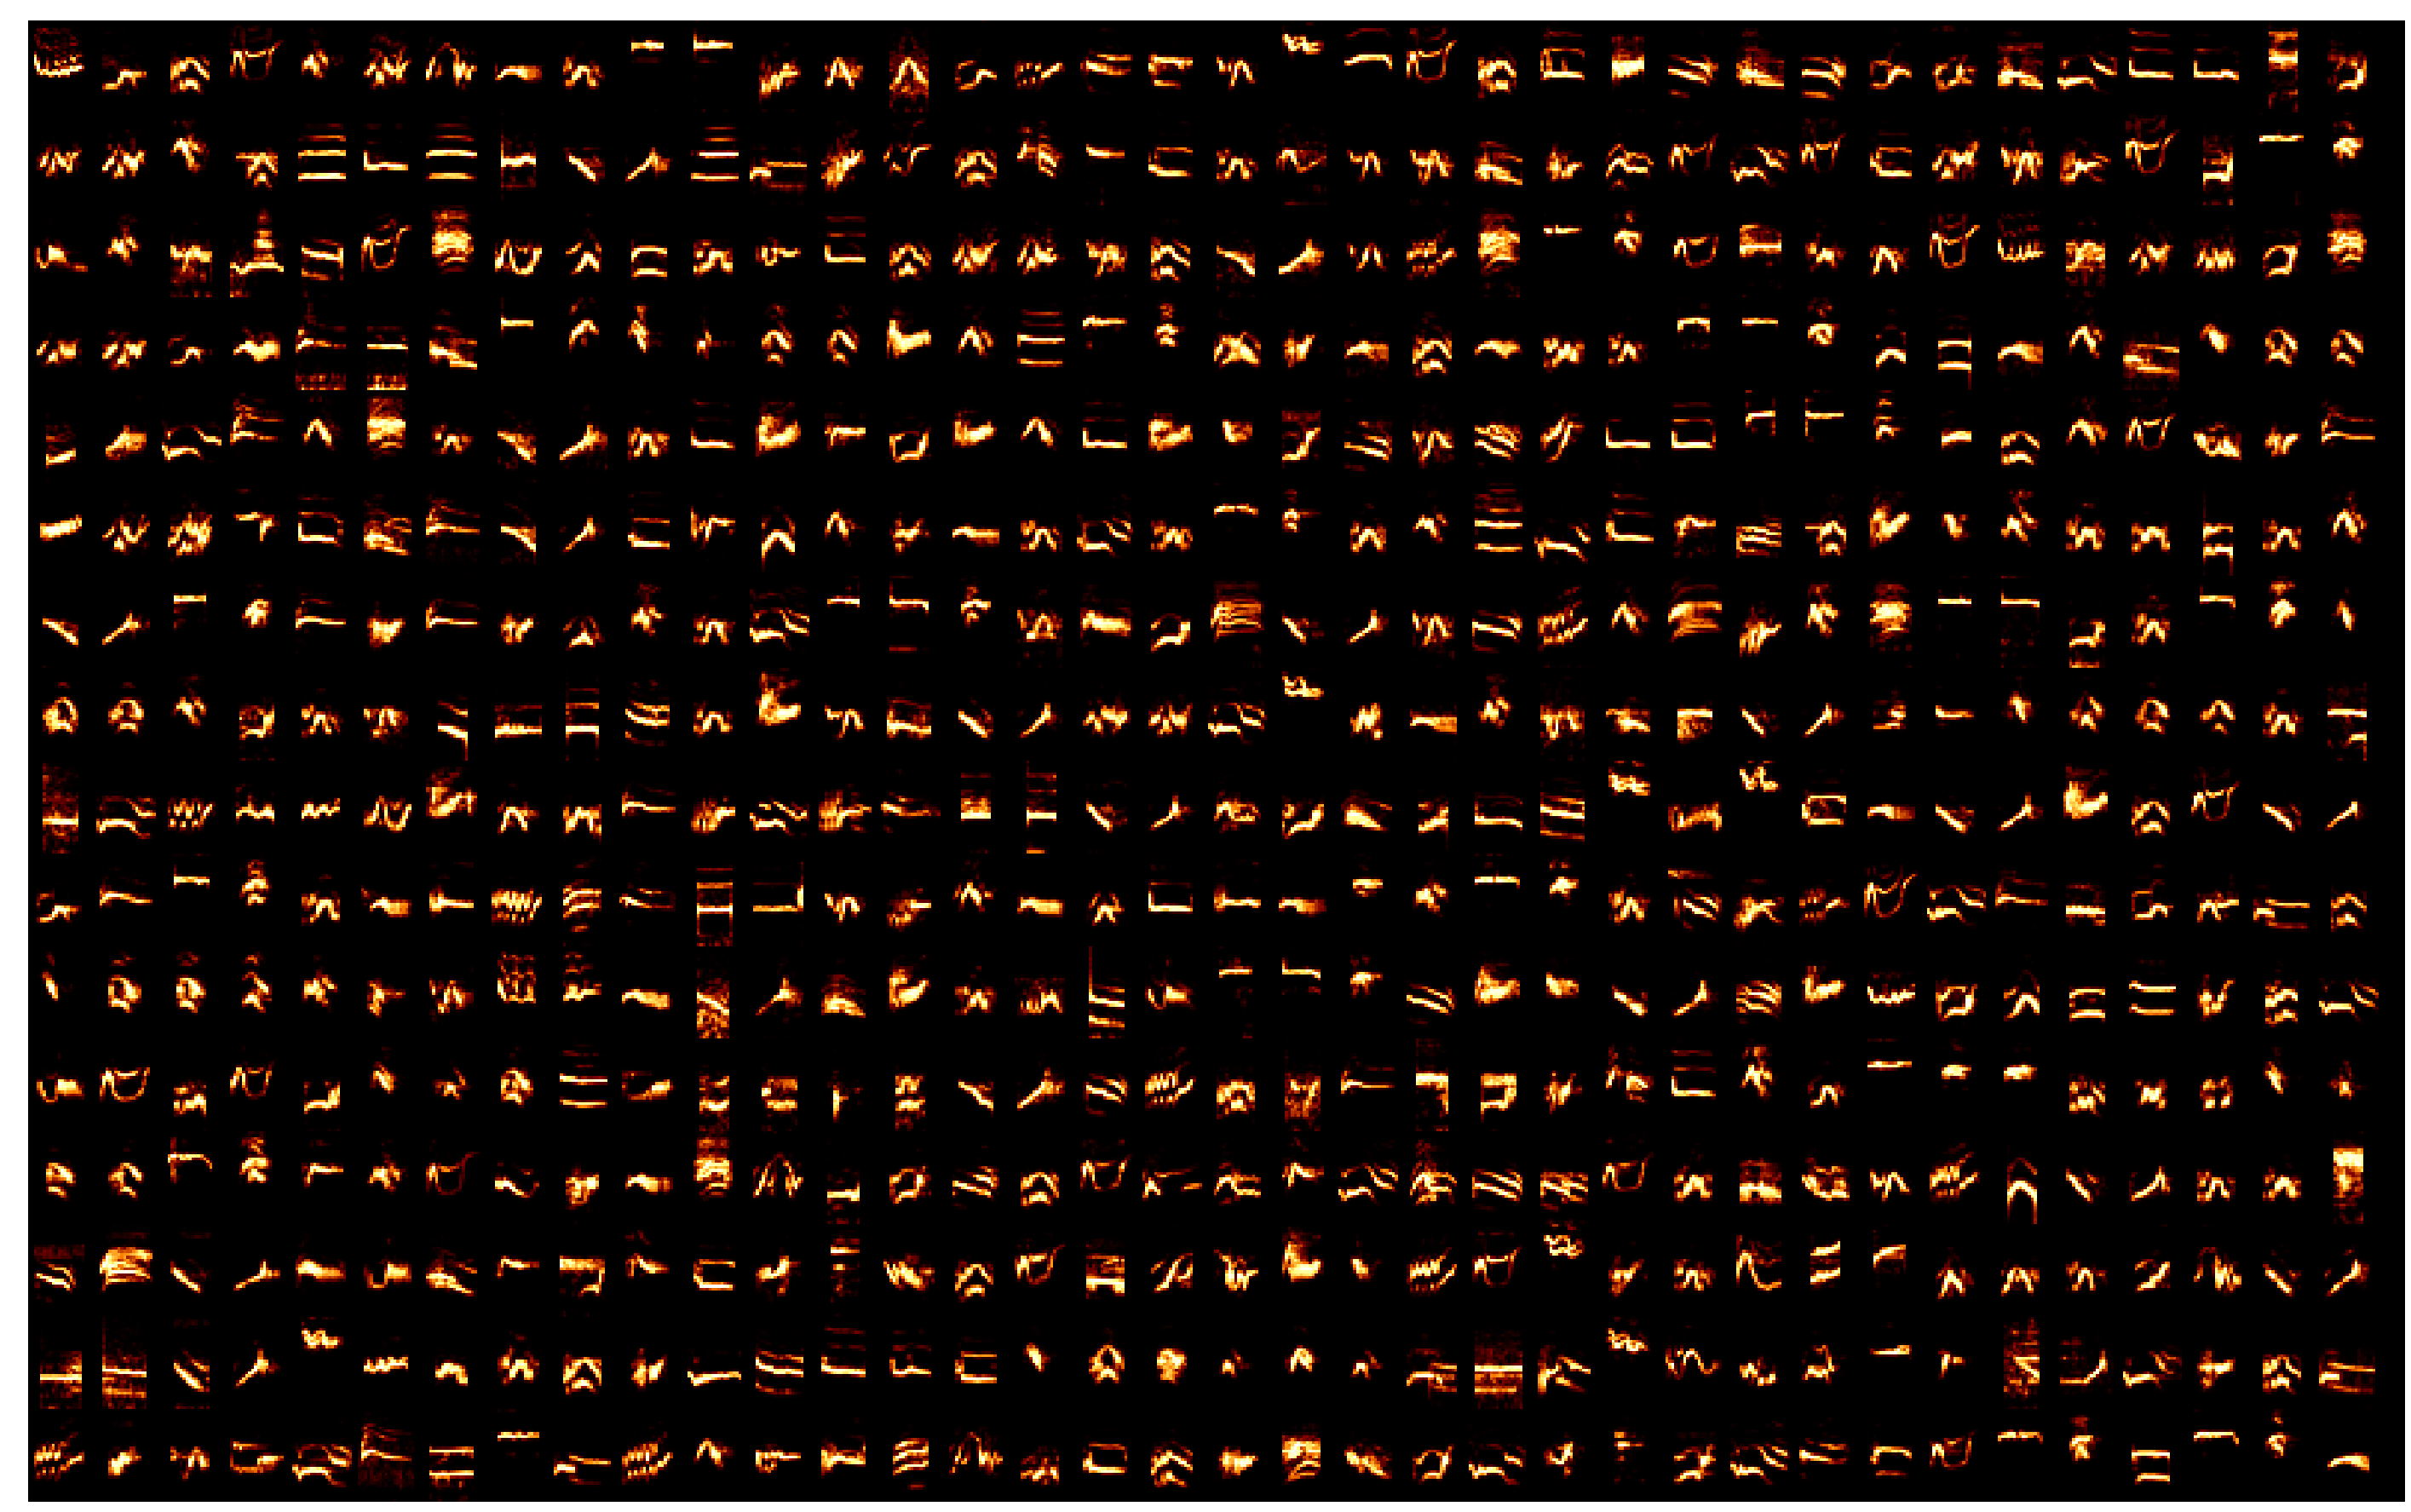

CATH-TLR9 2014


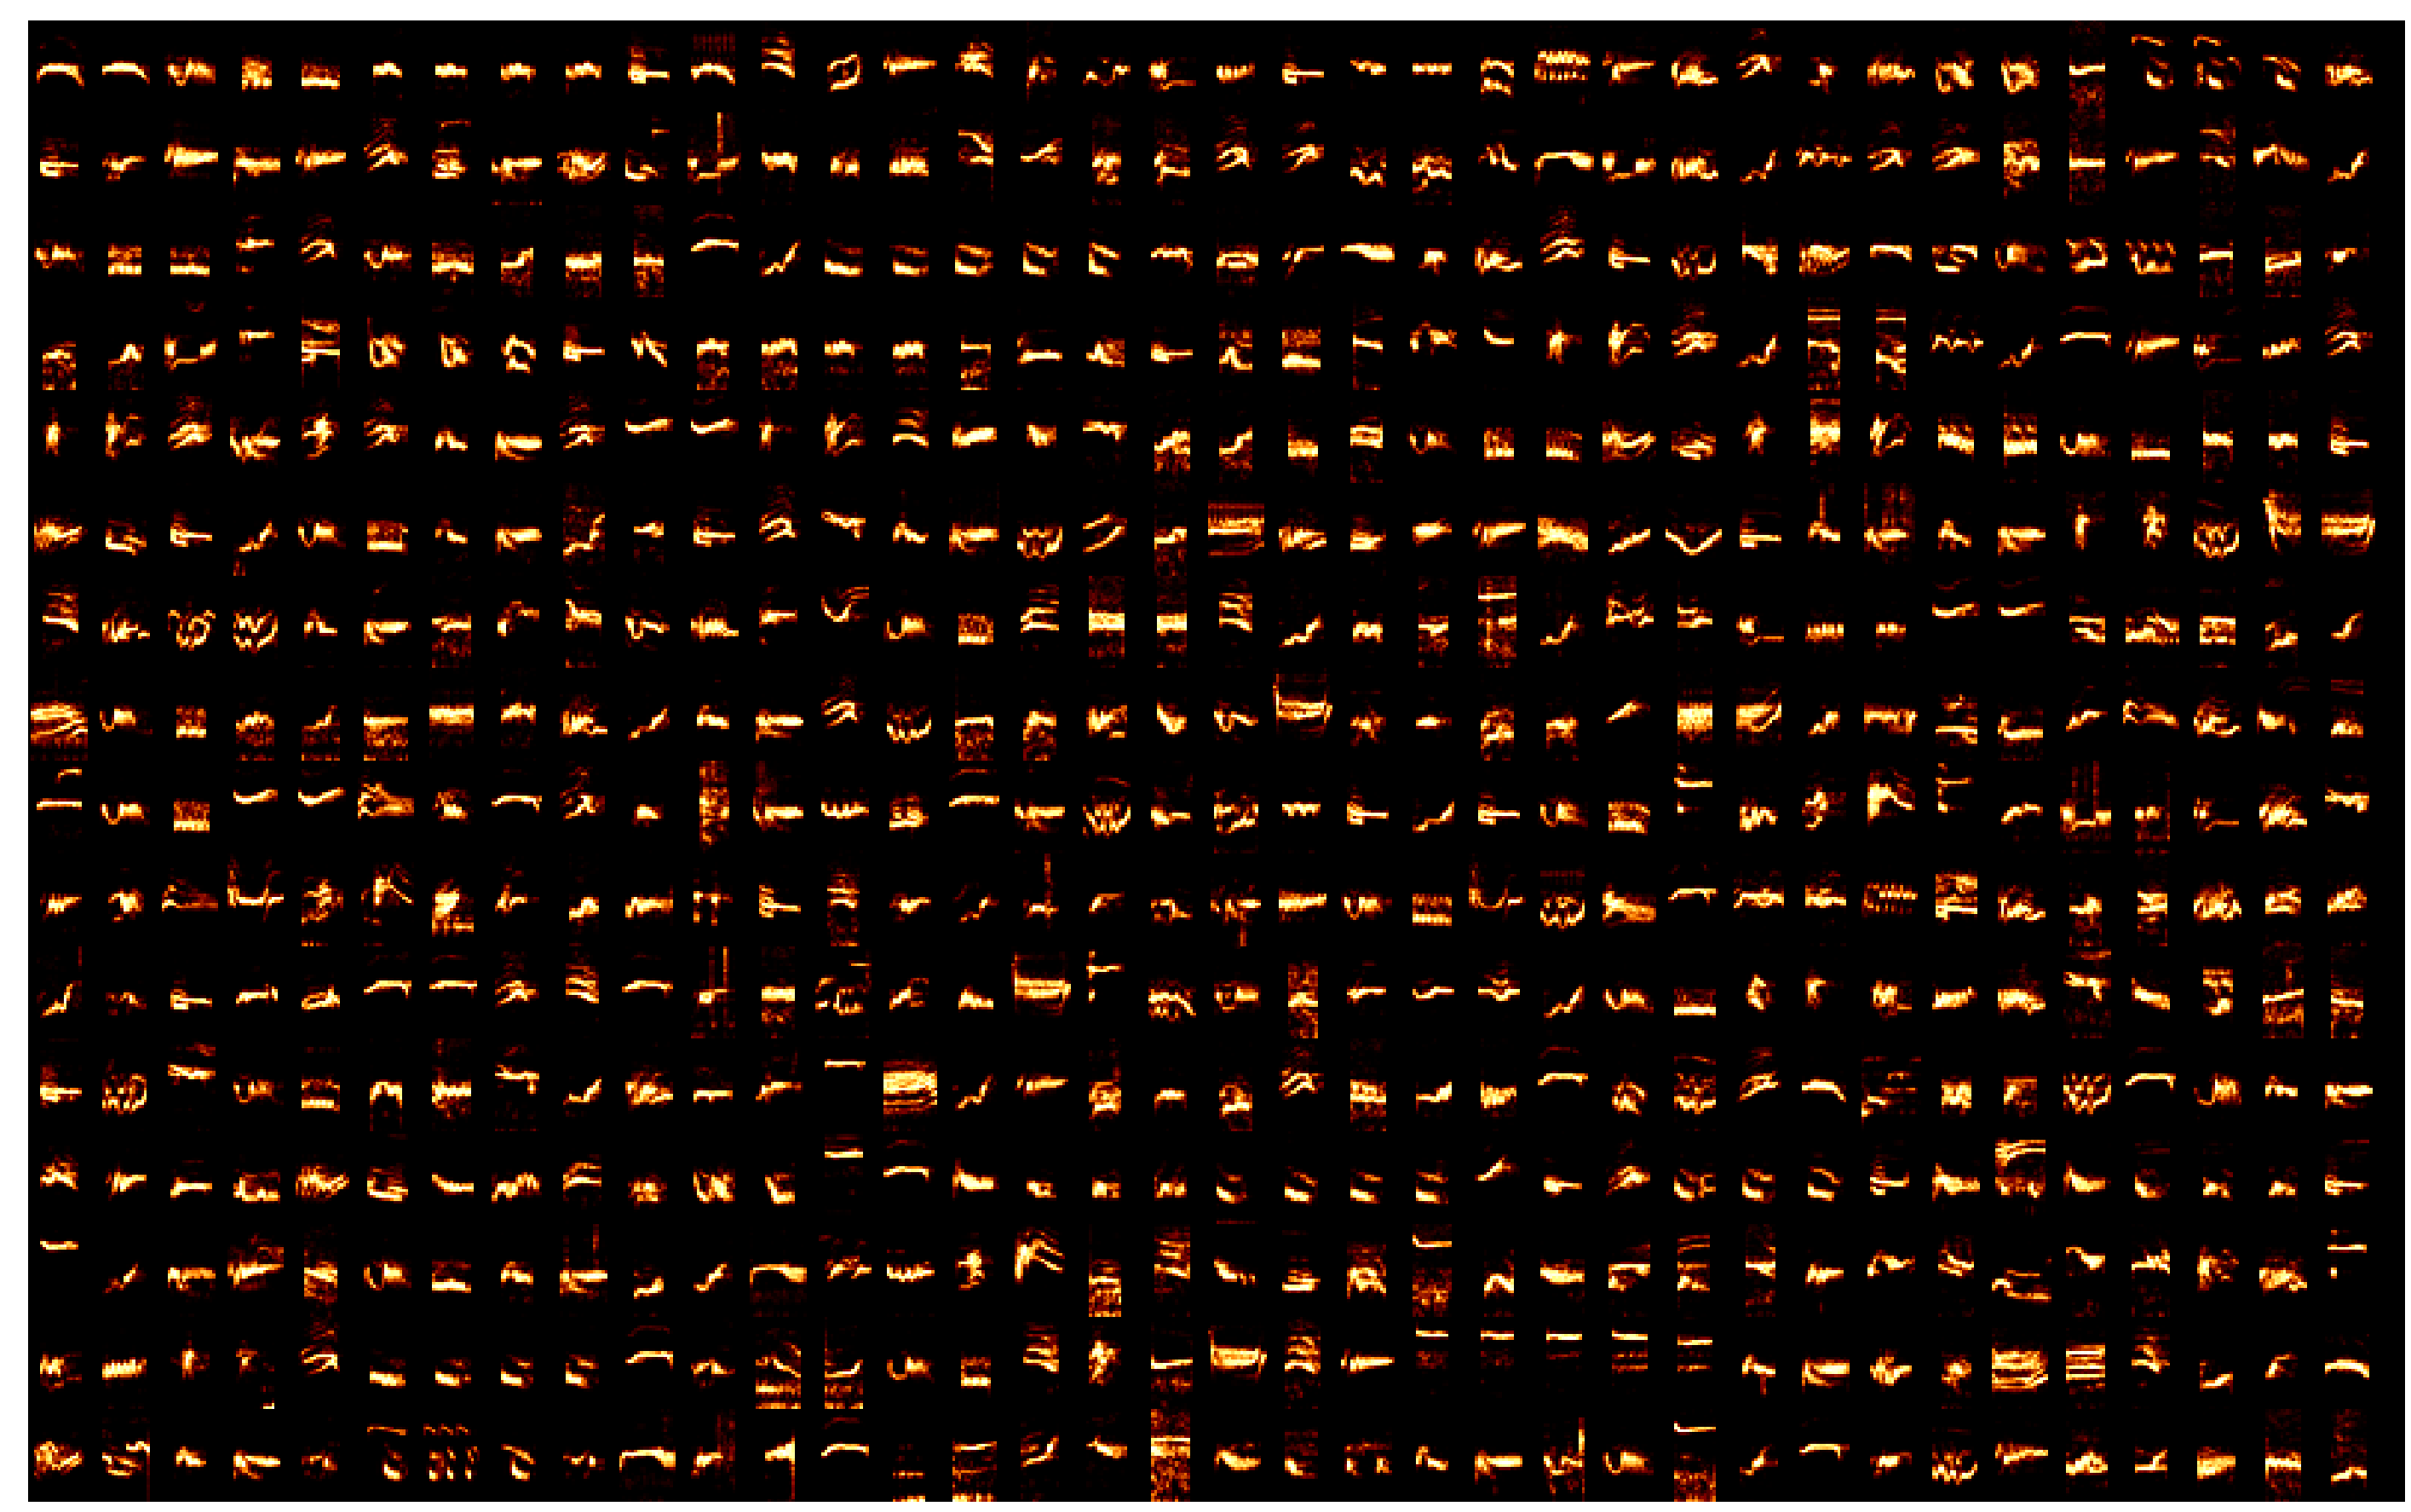

In [48]:
for indv in np.sort(syllable_df.indv.unique()[:5]):
    print(indv, np.sum(syllable_df.indv == indv))
    specs = np.array([i/np.max(i) for i in syllable_df[syllable_df.indv == indv].spectrogram.values])
    specs[specs<0] = 0
    draw_spec_set(specs, zoom=2,
                  maxrows=16, 
                  colsize=25)

### save dataset

In [49]:
save_loc = DATA_DIR / 'syllable_dfs' / DATASET_ID / 'thrasher.pickle'
ensure_dir(save_loc)
syllable_df.drop(columns = ['audio']).to_pickle(save_loc)